# Project 4: The Solar Atmosphere: Stratification and Continuous Spectrum

Candidate: 15904 and 15909

Imports needed to solve the following problems

In [1]:
%%javascript  # Allow equation numbers
MathJax.Hub.Config({
    TeX: { equationNumbers: { autoNumber: "AMS" } }
});

<IPython.core.display.Javascript object>

In [2]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
from astropy import units
from astropy import constants
from astropy.table import QTable  # to use tables with units
from astropy.modeling.models import BlackBody  # to compute the Planck function
from astropy.visualization import quantity_support
from IPython.display import set_matplotlib_formats
from numpy import newaxis as nax  # to simplify the many uses of this

quantity_support()
set_matplotlib_formats('svg')
plt.rc('legend', frameon=False)
plt.rc('figure', figsize=(7, 7 / 1.75)) # Larger figure sizes
plt.rc('font', size=12)

from scipy.integrate import cumtrapz   # for tau integration
from scipy.special import wofz   # for Voigt function

i_units = "kW m-2 sr-1 nm-1"  # More practical SI units

In [3]:
def read_table_units(filename):
    """
    Reads a table in a text file, formatted with column names in first row,
    and unit names on second row. Any deviation from this format will fail.
    """
    tmp = np.genfromtxt(filename, names=True)
    unit_names = open(filename).readlines()[1][1:].split()
    # Convert to astropy QTable to have units
    data = QTable(tmp)
    # Assign units to quantities in table, use SI units
    for key, unit in zip(data.keys(), unit_names):
        data[key].unit = unit
        data[key] = data[key].si  # We don't want to use deprecated units
    return data

### Exercise 1: The FALC Model


<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the total pressure $p_{\rm total}$ against the column mass $m$, both linearly and logarithmically.  You will find that they scale linearly.  Explain what assumption has caused $p_{\rm total} = c\,m$ and determine the value of the solar surface gravity $g_{\rm surface} = c$ that went into the FALC-producing code.
    
Answer:

</div>

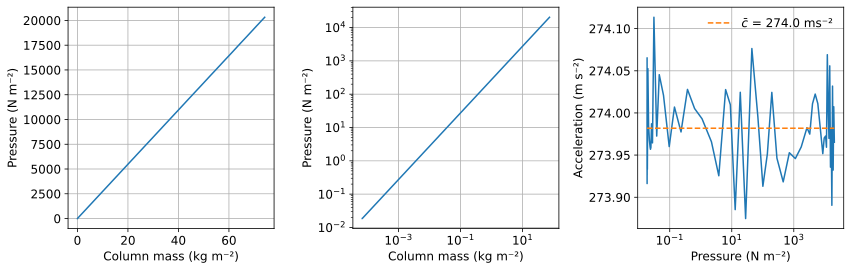

In [4]:
falc = read_table_units("falc.dat")

pressure = falc["pressure"]
colmass = falc["colmass"]

plt.figure(figsize=[12, 4])
plt.subplot(131)
plt.plot(colmass, pressure)
plt.grid()
plt.ylabel("Pressure (N m⁻²)")
plt.xlabel("Column mass (kg m⁻²)")

plt.subplot(132)
plt.loglog(colmass, pressure)
plt.grid()
plt.ylabel("Pressure (N m⁻²)")
plt.xlabel("Column mass (kg m⁻²)")

c = pressure/colmass
plt.subplot(133)
plt.plot(pressure, c)
plt.plot([pressure[0].value, pressure[-1].value], [np.mean(c.value), np.mean(c.value)], "--", label=r"$\bar{c}$ = %.1f ms⁻²" % np.mean(c.value))
plt.xlabel("Pressure (N m⁻²)")
plt.ylabel("Acceleration (m s⁻²)")
plt.xscale("log")
plt.legend()
plt.grid()
plt.tight_layout();


We notice from the left and middle (logarithmic) plot that the pressure $p_{\textrm total}$ is linearly dependent on the coloumn mass $m$. An explonation to this effect is that we assume all particles to traverse in lightspeed (???) since we get the relation $p_{\textrm{total}} = c m$ where $c$ is a acceleration factor. Solar atmosphere is horizontally homogeneous ("plane parallel layers") (???) and/or in hydrostatic equilibrium ("time independent") (???).




We have found that the acceleration $c$ are deviated in a relatively small matter around the mean which is $\bar{c} = 274.0$ ms⁻².

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* [Fontenla et al. (1993)](http://adsabs.harvard.edu/abs/1993ApJ...406..319F) also assumed complete mixing, *i.e.* the same elements mix at all heights. Check this by plotting the ratio of the hydrogen mass density to the total mass density against height. Then add helium to hydrogen using their abundance and mass ratios ($N_{\rm He}/N_{\rm H} = 0.1$, $m_{\rm He} = 3.97 \, m_{\rm H}$), and estimate the fraction of the total mass density made up by the remaining elements in the model mix (the "metals").
    
Answer:

</div>

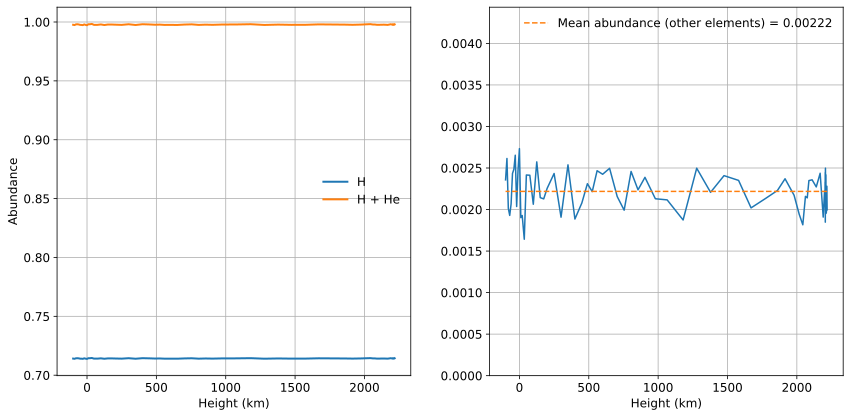

In [5]:
mass_H = constants.m_e + constants.m_p
density_H = falc["hydrogen_density"]
mass_density_H = mass_H * density_H

mass_He = 3.97 * mass_H
density_He = 0.1 * density_H
mass_density_He = mass_He * density_He

height = falc["height"].to('km')
density = falc["density"]

H_abund = mass_density_H / density
H_He_abund = (mass_density_H + mass_density_He)/density

plt.figure(figsize=[12,6])
plt.subplot(121)
plt.plot(height, H_abund, label="H", lw=2)
plt.plot(height, H_He_abund, label="H + He", lw=2)
plt.grid()
plt.legend()
plt.xlabel("Height (km)")
plt.ylabel("Abundance")

#plt.tight_layout()

plt.subplot(122)
rest_abund = 1 - H_He_abund
mean_abund = np.mean(rest_abund)
#plt.figure("Abundance of other elements", figsize=[12,6])
plt.plot(height, rest_abund)
plt.plot([height[0].value, height[-1].value], [mean_abund, mean_abund],
         "--", label="Mean abundance (other elements) = %.5f" % mean_abund)

plt.ylim([mean_abund-mean_abund, mean_abund+mean_abund])
plt.legend()
plt.grid()
plt.xlabel("Height (km)")

plt.tight_layout();


We notice that the abundance of other elements (i.e. not hydrogen or helium) are almost constant, i.e. close to an average of 0.00222 relatively speaking.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Create a plot of the gas pressure against height, and then overplot the product $(n_{\rm H} + n_{\rm e}) \, k_B T$. Plot the ratio of the two curves to show their differences.  Do the differences measure deviations from the ideal gas law or something else? Now add the helium density $n_{\rm He}$ to the product and enlarge the deviations. Do you see a pattern emerging? Comment on what could be missing between your calculations and the gas pressure from the model.
    
Answer:

</div>

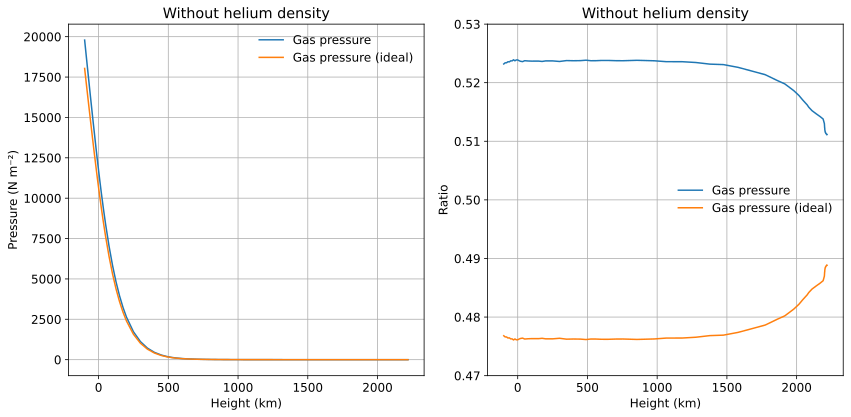

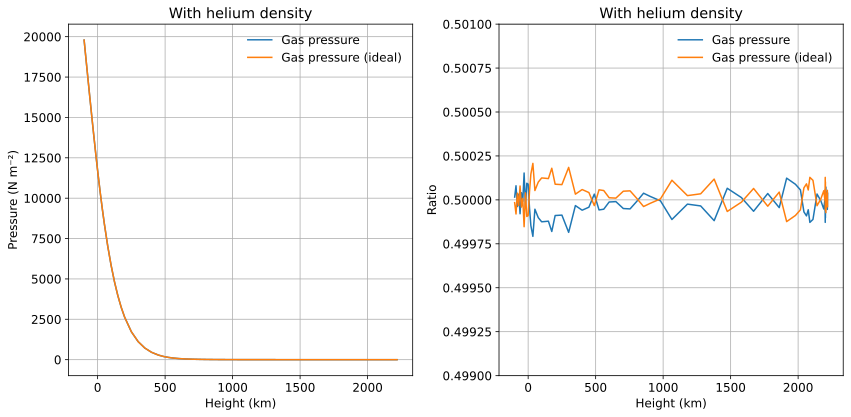

In [6]:
p_gas = falc["pressure"] - falc["density"] * falc["v_turb"]**2/2
p_gas_ideal = (falc["hydrogen_density"] + falc["electron_density"]) * constants.k_B * falc["temperature"]

plt.figure(figsize=[12, 6])
plt.subplot(121)
plt.title("Without helium density")
plt.plot(height, p_gas, label="Gas pressure")
plt.plot(height, p_gas_ideal, label="Gas pressure (ideal)")
plt.xlabel("Height (km)")
plt.ylabel("Pressure (N m⁻²)")
plt.legend()
plt.grid()


plt.subplot(122)
plt.title("Without helium density")
plt.plot(height, p_gas/(p_gas+p_gas_ideal), label="Gas pressure")
plt.plot(height, p_gas_ideal/(p_gas+p_gas_ideal), label="Gas pressure (ideal)")
plt.xlabel("Height (km)")
plt.ylabel("Ratio")
plt.legend()
plt.grid()
plt.ylim([0.47, 0.53])

plt.tight_layout()




p_gas = falc["pressure"] - falc["density"] * falc["v_turb"]**2/2
p_gas_ideal = (falc["hydrogen_density"] + falc["electron_density"] + density_He) * constants.k_B * falc["temperature"]

plt.figure("With He", figsize=[12, 6])
plt.subplot(121)
plt.title("With helium density")
plt.plot(height, p_gas, label="Gas pressure")
plt.plot(height, p_gas_ideal, label="Gas pressure (ideal)")
plt.xlabel("Height (km)")
plt.ylabel("Pressure (N m⁻²)")
plt.legend()
plt.grid()

plt.subplot(122)
plt.title("With helium density")
plt.plot(height, p_gas/(p_gas+p_gas_ideal), label="Gas pressure")
plt.plot(height, p_gas_ideal/(p_gas+p_gas_ideal), label="Gas pressure (ideal)")
plt.xlabel("Height (km)")
plt.ylabel("Ratio")
plt.legend()
plt.grid()
plt.ylim([0.499, 0.501])

plt.tight_layout();




We note from the upper left plot that there are difference pressure up until about 500 km. It is difficult to see the difference from that point, so we plotted instead the ratio between the two curves as seen from upper right plot. It is clear that there are deviations between the model and the ideal gas law. We remember from the previous plot above that hydrogen covers about 71 % of the total abundance which imply that some is missing. From the same previously plots, we have that helium covers about 28 % of the total abundance while the rest is other elements. If we add the helium density to the ideal gas law, we immediately see that the two different curves fits each other quite well as we see in the below plots.

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the ionisation fraction of hydrogen logarithmically against height. Why does this curve look like the temperature stratification plotted earlier? And why is it tilted with respect to that?
    
Answer:

</div>

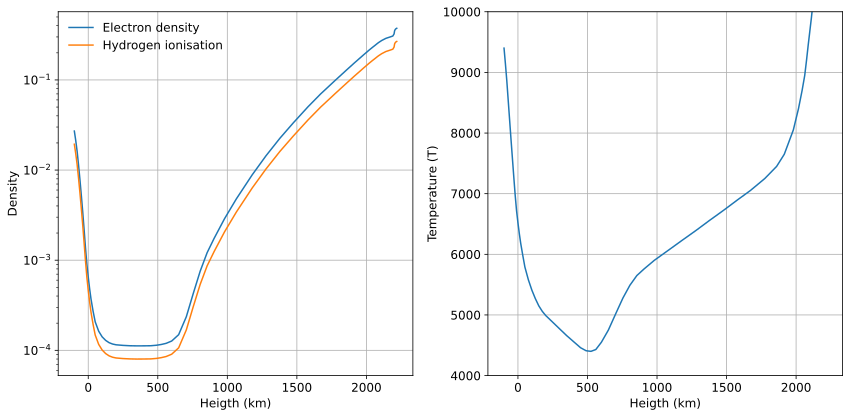

In [7]:
temperature = falc["temperature"]
tot_dens = falc["electron_density"] + falc["proton_density"] + falc["hydrogen_density"]

plt.figure("Density and temperature with height", figsize=[12,6])
plt.subplot(121)
plt.plot(height, falc["electron_density"]/tot_dens, label="Electron density")                 # hvem av dissa to plotta skal vi bruke?
plt.plot(height, H_abund*falc["electron_density"]/tot_dens, label="Hydrogen ionisation")      # hvem av dissa to plotta skal vi bruke?
plt.yscale("log")
plt.xlabel("Heigth (km)")
plt.ylabel("Density")
plt.legend()
plt.grid()

plt.subplot(122)
plt.plot(height, temperature)
plt.xlabel("Heigth (km)")
plt.ylabel("Temperature (T)")
plt.ylim(4000, 10000)
plt.grid()

plt.tight_layout();


<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Let us now compare the photon and particle densities. In thermodynamic equilibrium (TE) the radiation is isotropic with intensity $I_\nu = B_\nu$ and has total energy density (Stefan Boltzmann)
    \begin{equation*}
         u = \frac{1}{c} \int\!\!\!\int B_\nu \mathrm{d}\Omega \mathrm{d}\nu
           = \frac{4\sigma}{c} T^4,
      \end{equation*} so that the total photon density for isotropic TE radiation is given, with $u_\nu = \rm{d} u/\rm{d} \nu$, $T$ in K and $N_{\rm phot}$ in photons per m$^3$, by  
    \begin{equation*}
         N_{\rm phot} = \int_0^\infty \frac{u_\nu}{h\nu} \mathrm{d} \nu
            \approx 20\,T^3.
         \label{eq:20T3}
      \end{equation*} 
    This equation gives a reasonable estimate for the photon density at the deepest model location. Compute the value there and compare it to the hydrogen density. Conjecture why this equation is not valid higher up in the atmosphere. 
    
Answer:

</div>

'\nplt.subplot(122)\nplt.plot(height, falc["tau_500"])\nplt.yscale("log")\nplt.grid();\n'

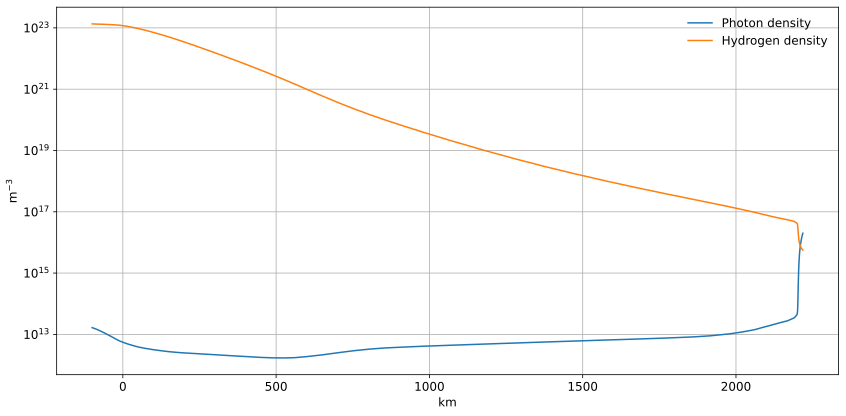

In [8]:
density_photon = (20 * temperature**3).value

plt.figure(figsize=[12,6])
#plt.subplot(121)
plt.plot(height, density_photon, label="Photon density")
plt.plot(height, density_H, label="Hydrogen density")
plt.yscale("log")
plt.legend()
plt.grid()

plt.tight_layout()

"""
plt.subplot(122)
plt.plot(height, falc["tau_500"])
plt.yscale("log")
plt.grid();
"""



???? The hydrogen density should not be greater than the photon density higher up in the atmosphere. The Sun should be densier at lower heights as the gravitation pulls down mass. Therefore it makes no sense why the hydrogen density is higher than the photon density. 

### Exercise 2: Observed Solar Continua

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Plot the four spectral distributions together in one figure over the range $\lambda$ = 0-2 μm. Check that the continuum intensity (`i_cont`) reaches $I_\lambda^c$ = 46 kW m$^{-2}$ nm$^{-1}$ sr$^{-1}$  at $\lambda$ 0.41 μm. Explain why the four distributions share the same units and discuss the differences between them.
    
Answer:

</div>

Plot the four spectral distributions together in one figure over the range  $\lambda  = 0-2 \mu m$. Check that the continuum intensity (i_cont) reaches $I^c_{\lambda} = 46$ kW m −2  nm −1  sr −1  at  $\lambda = 0.41 \mu m$.  SKRIV OM/MER

(0.0, 2.0)

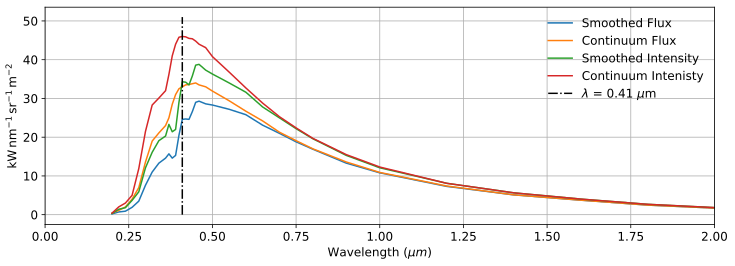

In [9]:
solspect = np.loadtxt("solspect.dat")
erg_s_cm2_um_sr = units.erg / units.s / units.cm**2 / units.um / units.sr * 10**10

Wavelength_solspect = solspect[:,0] * units.um
Flux_smooth = (solspect[:,1] * erg_s_cm2_um_sr).to(i_units)
Flux_cont = (solspect[:,2] * erg_s_cm2_um_sr).to(i_units)
Intensity_smooth = (solspect[:,3] * erg_s_cm2_um_sr).to(i_units)
Intensity_cont = (solspect[:,4] * erg_s_cm2_um_sr).to(i_units)

plt.figure(figsize=[12, 4])

plt.plot(Wavelength_solspect, Flux_smooth, label="Smoothed Flux")
plt.plot(Wavelength_solspect, Flux_cont, label="Continuum Flux")
plt.plot(Wavelength_solspect, Intensity_smooth, label="Smoothed Intensity")
plt.plot(Wavelength_solspect, Intensity_cont, label="Continuum Intenisty")
plt.plot([0.41,0.41],[0, (np.max(Intensity_cont)).value+5], "k-.", label="$\lambda$ = 0.41 $\mu$m")
plt.grid()
plt.legend()
plt.xlabel("Wavelength $(\mu m)$")
plt.xlim(0,2)


Explain why the four distributions share the same units and discuss the differences between them. SVAR HVERTFALL PÅ DETTE

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Convert these spectral distributions into values per frequency bandwidth $\Delta \nu$ = 1 Hz. Plot these also against wavelength. Check: peak $I_\nu^c$ = 4.21 nW m$^{-2}$ Hz$^{-1}$ sr$^{-1}$  at $\lambda$ = 0.80 μm.
    
Answer:

</div>

Next, we want to convert these spectral distributions into values per frequency bandwidth  $\delta \nu  = 1 Hz$. Plot these also against wavelength. Check: peak  $I^c_{\lambda}  = 4.21$ nW m −2  Hz −1  sr −1  at  $\lambda  = 0.80 \mu m$. SKRIV OM/MER!!!! presentere kode og hva vi gjorde for å komme fram til det uttrykket vi gjorde.

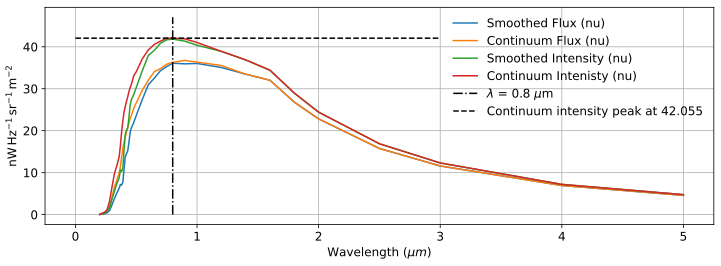

In [10]:
new_units = "nW m-2 sr-1 Hz-1"
nu = (constants.c / Wavelength_solspect).to("Hz")
dlam_dnu = (constants.c/(nu**2)).decompose()

Flux_smooth_nu = (Flux_smooth*dlam_dnu).to(new_units)            #solar smoothed flux
Flux_cont_nu = (Flux_cont*dlam_dnu).to(new_units)                #solar continuum flux
Intensity_smooth_nu = (Intensity_smooth*dlam_dnu).to(new_units)  #solar smooted intenisty
Intensity_cont_nu = (Intensity_cont*dlam_dnu).to(new_units)      #solar continuum intensity

peak = np.max(Intensity_cont_nu).value

plt.figure(figsize=[12, 4])
plt.plot(Wavelength_solspect, Flux_smooth_nu, label="Smoothed Flux (nu)")
plt.plot(Wavelength_solspect, Flux_cont_nu, label="Continuum Flux (nu)")
plt.plot(Wavelength_solspect, Intensity_smooth_nu, label="Smoothed Intensity (nu)")
plt.plot(Wavelength_solspect, Intensity_cont_nu, label="Continuum Intenisty (nu)")
plt.plot([0.8,0.8],[0, (np.max(Intensity_cont_nu)).value+5], "k-.", label="$\lambda$ = 0.8 $\mu$m")
plt.plot([0, 3], [peak,peak], "k--", label="Continuum intensity peak at 42.055")
plt.grid()
plt.legend()
plt.xlabel("Wavelength $(\mu m)$");

#relasjon mellom un og lamda er invers prop?

KOMMENTER

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Try to fit a Planck function to the solar continuum intensity. What rough temperature estimate do you get?
    
Answer:

</div>

Next, we want to fit a Planck function to the solar continuum intensity, and then find which temperature gives the best fitted curve. This we want to do in order ??
These calcualtions can be performed by use of the BlackBody function from astropy and calculate the difference between this function and the continuum intensity, so that we find where the error is smallest, which means where the Planck function is best fitted. When we know this, we can also find the temperature that gives this curve.

The temp at lowest error/where the Planck function is best fitted: [6308.29145729] K


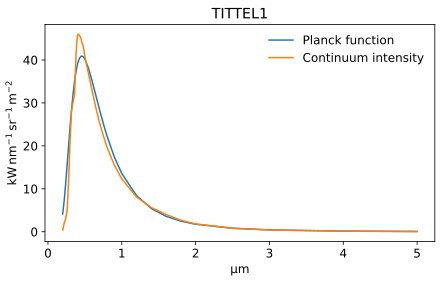

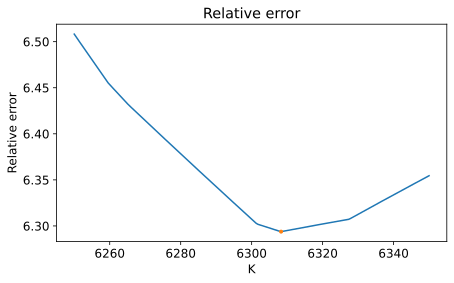

In [13]:
temperature_array = np.linspace(6250,6350,200)*units.K
error = np.zeros(len(temperature_array))

for i,T in enumerate(temperature_array):
    bb_Planck = (BlackBody(T, scale=1.0*units.kW / units.m**2 / units.nm /units.sr)
                (Wavelength_solspect.to("nm"))).value
    error[i] = np.sum(np.abs(bb_Planck - Intensity_cont.value) / (bb_Planck))

print("The temp at lowest error/where the Planck function is best fitted:", 
      temperature_array[np.where(error == np.min(error))])
    
plt.plot(Wavelength_solspect, BlackBody(temperature_array[np.where(error == np.min(error))], 
        scale=1.0*units.kW / units.m**2 /units.nm /units.sr)(Wavelength_solspect.to("nm")), 
        label="Planck function")
plt.plot(Wavelength_solspect, Intensity_cont, label="Continuum intensity")
plt.legend()
plt.title("TITTEL1")
plt.show()

plt.plot(temperature_array,error)
plt.plot(temperature_array[np.where(error == np.min(error))], np.min(error), ".")
plt.ylabel("Relative error")
plt.title("Relative error");


In these two plots, we observe that the best fitted Planck function to the continuum intensity is where the temperature is approximately 6308.29 K, which we see is where the relative error is smallest in the second plot. In the first plot, we see that the continuum intensity almost follows the Planck function perfectly, but the deviation is greatest in the beginning. The reason for this can be...???

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Invert the Planck function analytically to obtain an equation which converts an intensity distribution $I_\lambda$ into brightness temperature $T_b$ (defined by $B_\lambda(T_b) \equiv I_\lambda$). Code it as a function and use that to plot the brightness temperature of the solar continuum against wavelength. Discuss the shape of this curve. It peaks near $\lambda$ = 1.6 μm. What does that mean for the radiation escape at this wavelength?
    
Answer:

</div>

Now we want to invert the Planck function analytically, where we use the definition $B_\lambda(T_b) \equiv I_{\lambda}$, in order to obtain an equation which converts an intensity distribution $I_\lambda$ into brightness temperature $T_b$. By doing this we can find the maximimum brightness temperature and observe which wavelength this temperature corresponds to. We will perform these calculations by first rewriting the Planck function,

\begin{equation}
 \tag{NUMMER}
 \label{Eq_planck}
 B_{\lambda}(T_b) \equiv I_{\lambda} = \frac{2hc^2}{\lambda^5} \frac{1}{e^{\frac{hc}{\lambda k_B T_b} -1}},
\end{equation}
to an expression for $T_b$ expressed with both $\lambda$ and $I_{\lambda}$,
\begin{equation}
 \tag{NUMMER2}
 \label{Eq_Tb}
 T_b = \frac{hc}{\lambda k_B \text{ln}\Big[ \frac{2hc^2}{\lambda^5 I_{\lambda}} +1 \Big]}.
\end{equation}

We then want to plot the brightness temperature of the solar continuum against wavelength. We want to use astropy when performing these calculations, which means that we need to multiply the Intensity with sr in order to make it unitless before creating the plot.


The maximal brightness temperature:  6711.388150994749 K


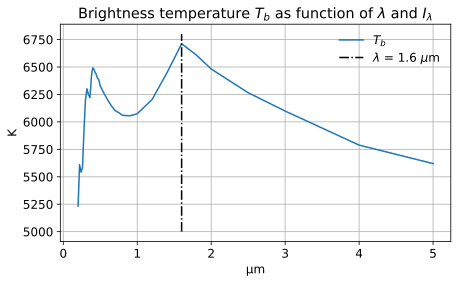

In [14]:
c = constants.c
h = constants.h
kb = constants.k_B

def T_func(Int):
    T_value = (h*c) / (Wavelength_solspect * kb * np.log((2*h*(c**2)) 
            / (Wavelength_solspect**5 * Int) + 1))
    return T_value


print("The maximal brightness temperature: ", np.max(T_func(Intensity_cont*units.sr).decompose()))

plt.plot(Wavelength_solspect, T_func(Intensity_cont*units.sr).decompose(), label="$T_b$")
plt.plot([1.6,1.6],[5000, 6800], "k-.", label="$\lambda$ = 1.6 $\mu$m")
plt.title("Brightness temperature $T_b$ as function of $\lambda$ and $I_{\lambda}$")
plt.grid()
plt.legend();

Discuss the shape of this curve. It peaks near  𝜆  = 1.6 μm. What does that mean for the radiation escape at this wavelength?

den temp vi måler basert på hvor mye intensitet vi får.
gitt denne int/flux, hvilken temp må denne ha for å 

hvilken temp må et legeme ha for at den skal avgi den intensiteten jeg mottar - planck.



 What does that mean for the radiation escape at this wavelength?
 hvis du må ha høy temp for gitt int - vanskelig å komme gjennom. 
 absorbtions-topper, aka linjer, abs linjer?


### Exercise 3: Continuous Extinction

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Using the function `compute_hminus_cross_section`, compute and plot the H$^-$ extinction for wavelengths between 300-1000 nm, and for the temperature and density at the solar surface (height = 0) in the FALC model.
    
Answer:

</div>

Compute and plot the H−  extinction for wavelengths between 300-1000 nm, and for the temperature and density at the solar surface (height = 0) in the FALC model. 

In [15]:
def compute_hminus_cross_section(wavelength, temperature, electron_density):
    """
    Computes the H minus extinction cross section, both free-free and
    bound-free as per Gray (1992).
    
    Parameters
    ----------
    wavelength : astropy.units.quantity (array)
        Wavelength(s) to calculate in units of length.
    temperature: astropy.units.quantity (scalar or array)
        Gas temperature in units of K or equivalent.
    electron_density: astropy.units.quantity (scalar or array)
        Electron density in units of per cubic length.
        
    Returns
    -------
    extinction : astropy.units.quantity (scalar or array)
        Total H- extinction in si units. 
        Shape: shape of temperature + (nwave,)
    """
    # Broadcast to allow function of temperature and wavelength
    temp = temperature[..., nax]
    wave = wavelength[nax]
    theta = 5040 * units.K / temp
    electron_pressure = electron_density[..., nax] * constants.k_B * temp
    # Compute bound-free opacity for H-, following Gray 8.11-8.12
    sigma_coeff = np.array([2.78701e-23, -1.39568e-18,  3.23992e-14, -4.40524e-10,
                               2.64243e-06, -1.18267e-05,  1.99654e+00])
    sigma_bf = np.polyval(sigma_coeff, wave.to_value('AA'))
    sigma_bf = sigma_bf * 1.e-22 * units.m ** 2
    # Set to zero above the H- ionisation limit at 1644.4 nm
    sigma_bf[wave > 1644.2 * units.nm] = 0.
    # convert into bound-free per neutral H atom assuming Saha,  Gray p156
    k_const = 4.158E-10 * units.cm ** 2 / units.dyn
    gray_saha = k_const * electron_pressure.cgs * theta ** 2.5 * 10. ** (0.754 * theta)
    kappa_bf = sigma_bf * gray_saha                    # per neutral H atom
    # correct for stimulated emission
    kappa_bf *= (1 - np.exp(-constants.h * constants.c / (wave * constants.k_B * temp))) 

    # Now compute free-free opacity, following Gray 8.13
    # coefficients for 4th degree polynomials in the log of wavelength (in AA)
    coeffs = np.array([[-0.0533464, 0.76661, -1.685, -2.2763],
                          [-0.142631, 1.99381, -9.2846, 15.2827],
                          [-0.625151, 10.6913, -67.9775, 190.266, -197.789]], dtype="object")
    log_wave = np.log10(wave.to_value('AA'))
    log_theta = np.log10(theta.value)
    tmp = 0
    for i in range(3):
        tmp += np.polyval(coeffs[i], log_wave) * (log_theta ** i)
    kappa_ff = electron_pressure * (10 ** tmp) 
    kappa_ff = kappa_ff * 1e-26 * (units.cm ** 4) / units.dyn
    return kappa_bf + kappa_ff.si


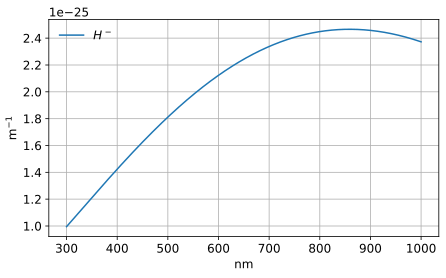

In [29]:
wave = np.linspace(300,1000,1000)*units.nm              #nm
t_0 = temperature[np.where(height==0)]                  #K
dens_0 = falc["electron_density"][np.where(height==0)]  #m-3
H_density = 1020 * (units.m   **(-3))                   #m-3
H_ext = np.concatenate(compute_hminus_cross_section(wave, t_0, dens_0))*H_density #m2  #skal vi gange denne med en H- density, så vi får m-1 enhet???

plt.plot(wave,H_ext, label="$H^-$")
#plt.title("TITTEL")
plt.grid()
plt.legend();

HVA SER VI HER?

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Hydrogenic bound-free edges behave just as H$^-$ with maximum extinction at the ionisation limit and decay $\sim \lambda^3$ for smaller wavelengths, as indeed shown by the H$^-$ curve. The H$^-$ bound-free extinction differs strongly from this pattern. Why is it not hydrogenic although due to hydrogen?
    
Answer:

</div>

bf ???

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* How should you plot this variation to make it look like the solar brightness temperature variation with wavelength? Why?
    
Answer:

</div>

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Compute and plot the H$^-$ extinction as a function of height for the FALC model, at $\lambda$ = 0.5 μm. This plot needs to be logarithmic in y, why?
    
Answer:

</div>

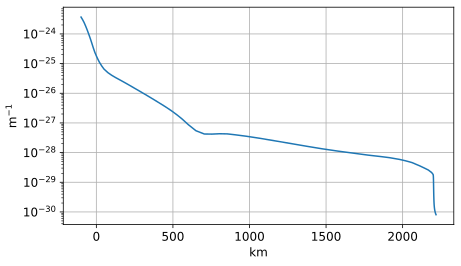

In [34]:
height_FALC = falc["height"].to("km")
e_dens = falc["electron_density"] #m-3
H_ext2 = np.concatenate(compute_hminus_cross_section((0.5*units.um), temperature, e_dens))*H_density #m2 

plt.plot(height_FALC, H_ext2)
plt.yscale("log")
#plt.title("TITTEL")
plt.grid();

<div style="background-color:#e6ffe6; padding:10px; border-style: solid;; border-color:#00e600; border-width:1px">
    
* Now add the Thomson scattering off free electrons to the extinction per m. The Thomson cross-section per electron is the same at all wavelengths and is given by       
\begin{equation*}
        \sigma^{\rm T} = 6.652 \times 10^{-29} \rm{m}^2.
\end{equation*} 
By which height-dependent quantity do you have to multiply this number to obtain extinction per m? Overplot this contribution to the continuous extinction $\alpha_\lambda^c(h)$ in your graph and then overplot the total continuous extinction too.  Note where which effect dominates.
    
Answer:

</div>